# Rolling Window Quantile cruncher

This cruncher is best for use in larger databases. It calculates a given quantile of the relationship between lead and follow data in the infiller database, then infills the corresponding value for the infillee data. By default this quantile is 0.5, i.e. we infill the median value. Using higher values (up to 1) will result in higher emissions of the gas being infilled. It is the only cruncher that can generate a distribution of values rather than simply the best estimate. 

In [1]:
import traceback
import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    get_sr15_scenarios,
    download_or_load_sr15,
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Collecting data
We get data from the IIASA database as in earlier notebooks

In [2]:
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "WITCH*",
]
sr15_data = download_or_load_sr15("./sr15_scenarios.csv", valid_model_ids)

pyam.utils - INFO: Reading `./sr15_scenarios.csv`


The documentation describes how it works: 

In [3]:
print(silicone.database_crunchers.QuantileRollingWindows.__doc__)


    Database cruncher which uses the 'rolling windows' technique.

    This cruncher derives the relationship between two variables by performing
    quantile calculations between the follower timeseries and the lead timeseries.
    These calculations are performed at each timestep in the timeseries, independent
    of the other timesteps.

    For each timestep, the lead timeseries axis is divided into multiple evenly spaced
    windows (to date this is only tested on 1:1 relationships but may work with more
    than one lead timeseries). In each window, every data point in the database is
    included. However, the data points receive a weight given by

    .. math::

        w(x, x_{\text{window}}) = \frac{1}{1 + (d_n)^2}

    where :math:`w` is the weight and :math:`d_n` is the normalised distance between
    the centre of the window and the data point's position on the lead timeseries axis.

    :math:`d_n` is calculated as

    .. math::

        d_n = \frac{x - x_{\text{window}

## Infilling

Because it relies on quantile analysis, this cruncher gives smoother results with large amounts of data (though filtering out irrelevant scenarios can still be helpful). It also only returns values found in the database (unless `use_ratio` is `True`), so will produce more variation the more data it is given. We filter results in this example to improve the runtime. In most cases we will not want to change the quantile from 0.5. 

In [4]:
sr15_data_quantile = sr15_data.filter(
    model=["WITCH-GLOBIOM 4.2"], variable=["Emissions|CO2", "Emissions|VOC"]
)
sr15_data_quantile.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
237108,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2005,0,0.0,31743.82847
237109,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2010,0,0.0,34057.08892
237110,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2015,0,0.0,35659.76850
237111,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2020,0,0.0,37303.32932
237112,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2025,0,0.0,21322.81018


In [5]:
cruncher = silicone.database_crunchers.QuantileRollingWindows(
    sr15_data_quantile
)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)


            Filler function derived from :obj:`QuantileRollingWindows`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key db_times for filling are not in ``in_iamdf``.
            


Now we can infill a scenario. 

In [6]:
filler_input = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600"
)

The `filler_input` is missing `Emissions|VOC`.

In [7]:
filler_input.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,meta,subannual,value


The rolling windows quantile can only work on the timesteps in the infiller database. If we input times that aren't there, we will receive a `ValueError`.

In [8]:
try:
    filler(filler_input)
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Not all required timepoints are present in the database we crunched, we crunched 
	`[2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]`
but you passed in 
	[2000, 2005, 2010, 2015, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]


We can fix this by filtering the years we ask for, or using a bigger infiller database.

In [9]:
filler_data = filler_input.filter(
    year=sr15_data_quantile["year"].unique(), variable="Emissions|CO2"
)
filler_data.timeseries()

,,,,,,,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,0,0.0,35933.0697,38542.01816,39615.22255,37981.07524,33271.92656,25181.95619,13847.19271,5163.226383,-2068.503671,-7525.726077,-10662.64286


Now we can infill:

In [10]:
filled = filler(filler_data)
filled.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,189.212000
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,164.056724
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,145.611005
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,0,0.0,115.465871
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,0,0.0,86.915793


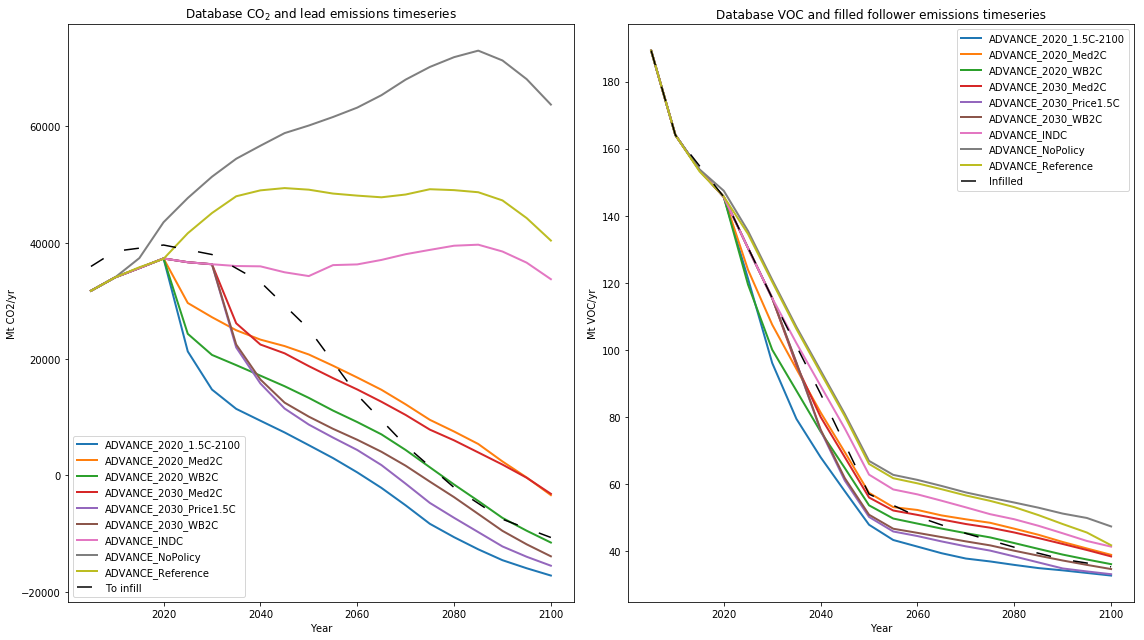

In [11]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill"
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filled.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled"
)
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

The quantiles do not stick to a single timeline, so unlike in the RMS closest cruncher, we can move between different values found in the infiller database. However we still cannot return values outside of the distribution of inputs, unless we use this cruncher in ratio mode. 

## Recovering the data you put in

This section does not illustrate new functionality, merely investigates the mathematical effects of changing the number of windows.

Because of the averaging mechanism, the cruncher will only precisely reproduce the input data when there is only one timeseries in the infiller database. With multiple data series, this is not guaranteed, although will happen in the limit case of very localised weighting, represented by changing either `nwindows` or `decay_length_factor`. Both of these refer to how the rolling windows are calculated. The first of these controls how many points the windows are calculated at, the second weights points closer to the window center more strongly. The mathematical details can be found in the documentation, but we generally do not advise changing `decay_length_factor`. We explore below the effects of using the whole database on the infiller. 

In [12]:
# Multiple data are input - the 50th percentile and nwindows=10 is the default
filler_data = sr15_data_quantile.filter(scenario="ADVANCE_2030_Med2C")
self_cruncher = silicone.database_crunchers.QuantileRollingWindows(sr15_data)
self_filler_default = self_cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|VOC"], nwindows=10
)
infilled_quantile = self_filler_default(filler_data)

The default behaviour shows the correct trend, but the windows-based interpolation introduces some noise.

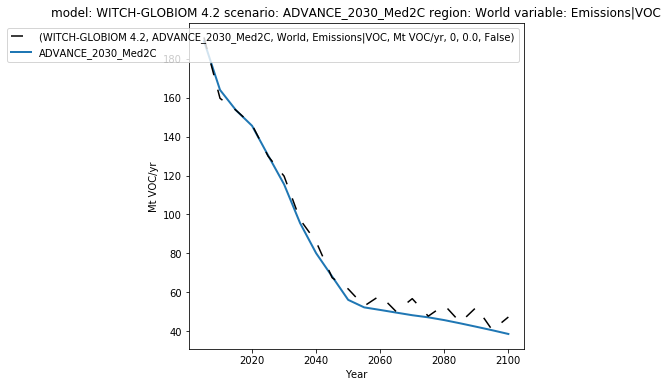

In [13]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
filler_data.filter(variable="Emissions|VOC",).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable="Emissions|VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(8, 10)
)
# To see all the infiller data, uncomment the line below:
# sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

By increasing the windows number, we can get a higher fidelity - at the cost of more computational power and less averaging over different datapoints (i.e. potentially more spiky behaviour). 

In [14]:
# With a lower window number, the deviations become clearer
self_filler_low_w = self_cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|VOC"], nwindows=2
)
infilled_low_w = self_filler_low_w(filler_data)
# Higher window numbers mean that we weight data with the exact same x-value more highly, recovering the original relation
self_filler_high_w = self_cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|VOC"], nwindows=30
)
infilled_high_w = self_filler_high_w(filler_data)

Here the lower window count (blue) results in large deviations from the local data (towards to median value at that time) whereas the high window case (red) provides a close match. If you want to see all the trend lines on the graph at the same time, uncomment a line below. 

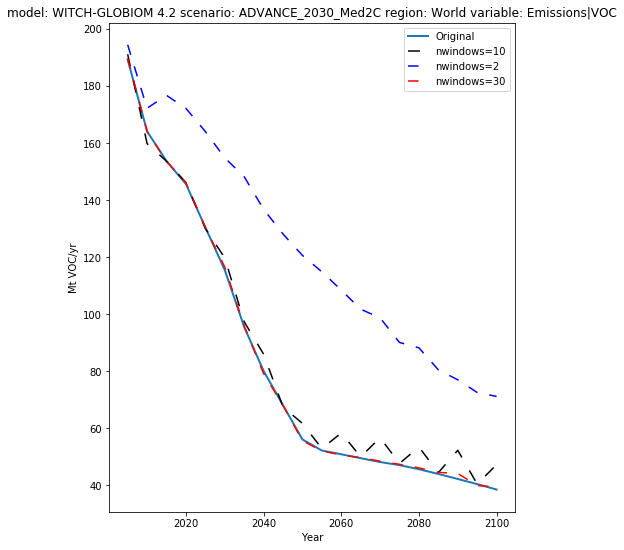

In [15]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
filler_data.filter(variable="Emissions|VOC",).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable="Emissions|VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(8, 10)
)
infilled_low_w.line_plot(ax=ax, color="blue", linestyle="--", dashes=(7, 8))
infilled_high_w.line_plot(ax=ax, color="red", linestyle="--", dashes=(7, 8))
plt.legend(["Original", "nwindows=10", "nwindows=2", "nwindows=30"])
# This line illustrates the background data informing the deviations (but confuses the plots).
# Re-add it if desired:
# sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

#### Quantile rolling window ratio option
The quantile rolling window infiller has a `use_ratio` option that defaults to false. If set to true, instead of infilling the value found using the above process, it uses the ratio between the lead and follow data. This ratio is found using rolling weighted windows as above, and is typically the median value. Having found the ratio, it multiplies it by the value of the lead variable in the infillee database at the appropriate time. We recommend not to use this if the lead or follow variable changes sign. 

In [16]:
filler_input = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600"
)
filler_data = filler_input.filter(
    year=sr15_data_quantile["year"].unique(), variable="Emissions|CO2"
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], use_ratio=True
)
infilled = filler(filler_data)

The graphs below show that these results are also reasonable, and allow for infilled values outside the range in the infiller database. However there is some degree of irregularity when the lead variable goes negative, and potentially a sign error could occur here. 

Text(0.5, 1.0, 'Database VOC and filled follower emissions timeseries')

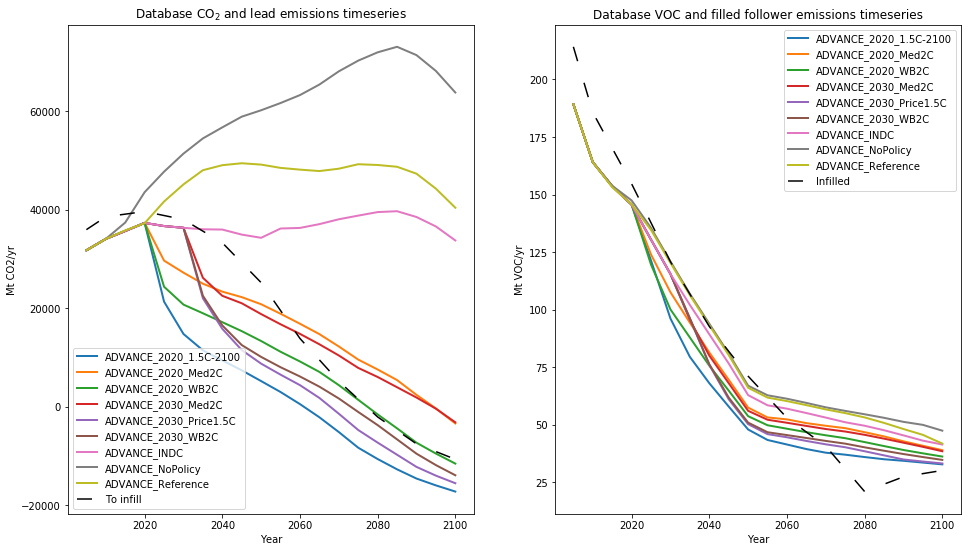

In [17]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill"
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
infilled.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled"
)
ax.set_title("Database VOC and filled follower emissions timeseries")

## Other quantiles
Using quantiles other than 0.5 is possible, but needs to be done with caution. Note that a higher quantile always corresponds to a higher level of emissions, even if the lead and follow emissions type may anticorrelate (e.g. SF6 emissions may increase as CO2 emissions decrease). This means that crunching many variables with the same quantile (not 0.5) will introduce additional correlation between these. The main use-case is with a randomly generated or portfolio of values (independent for each gas infilled) to generate a portfolio of possible pathways. 

Text(0.5, 1.0, 'VOC when infilling with different quantiles, default window parameters')

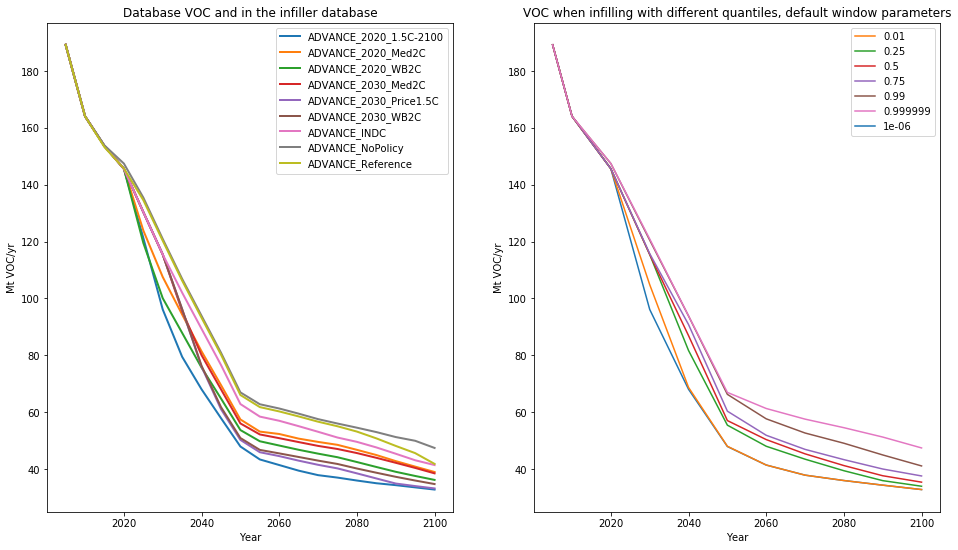

In [18]:
all_quant = [1e-6, 0.01, 0.25, 0.5, 0.75, 0.99, 1 - 1e-6]
all_infilled = []
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
ax.set_title("Database VOC and in the infiller database")
ax = fig.add_subplot(122)
for quant in all_quant:
    filler = cruncher.derive_relationship(
        "Emissions|VOC", ["Emissions|CO2"], quantile=quant
    )
    all_infilled.append(filler(filler_data))
    all_infilled[-1].filter(variable="*VOC").line_plot(ax=ax, label=quant)
ax.set_title(
    "VOC when infilling with different quantiles, default window parameters"
)

Here we see that for sufficiently extreme quantiles, we will reconstruct the whole range of possible values, however even the top and bottom 0.01 do not reach the most extreme values, since the spread of lead variables is very large. To have more representation from distant values of the lead variables, we can decrease the `decay_length_factor`. Larger values of this means a slower roll-off of the rolling window, so more extreme outputs are accessed at less extreme quantiles. With decay length 100, below, we see that there is no longer a difference between 0.01 and 0.000001 quantiles. 

Text(0.5, 1.0, 'VOC when infilling with different quantiles, decay_length_factor=100')

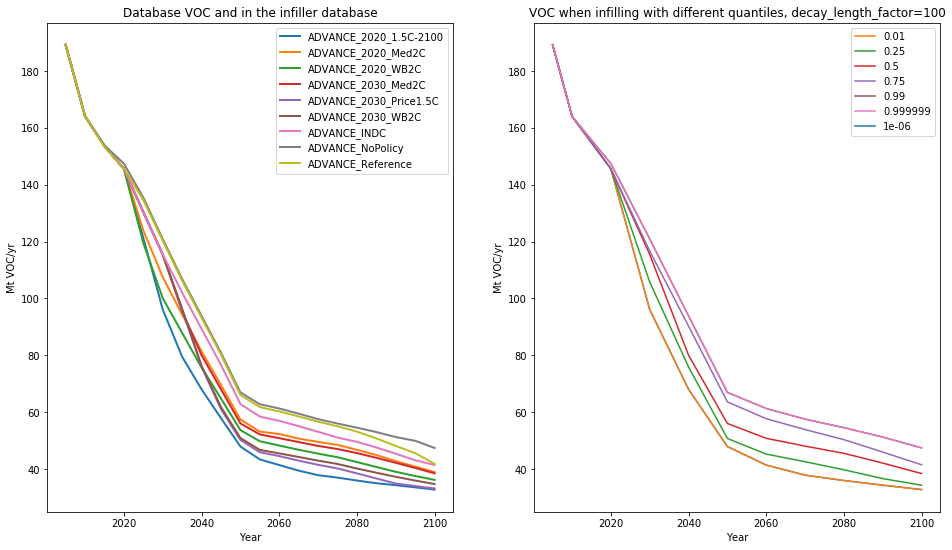

In [19]:
all_quant = [1e-6, 0.01, 0.25, 0.5, 0.75, 0.99, 1 - 1e-6]
all_infilled = []
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
ax.set_title("Database VOC and in the infiller database")
ax = fig.add_subplot(122)
for quant in all_quant:
    filler = cruncher.derive_relationship(
        "Emissions|VOC",
        ["Emissions|CO2"],
        quantile=quant,
        decay_length_factor=100,
    )
    all_infilled.append(filler(filler_data))
    all_infilled[-1].filter(variable="*VOC").line_plot(ax=ax, label=quant)
ax.set_title(
    "VOC when infilling with different quantiles, decay_length_factor=100"
)